### Lab-V: Space-variant Blurring

Ayush Mukund Jamdar EE20B018

Here we extend the previous lab assignment that worked around space-invariant blurring to understand space-variant blurring. 

In [20]:
# load modules
import numpy as np
from PIL import Image # for image loading and saving
from IPython.display import display

# Convert a grayscale png/jpg image to a numpy array
# of ints 0 to 256
def image2array(filename, colour=False):
    image = Image.open(filename)

    if colour:
        image = image.convert('L')
        image = image.resize((800, 500))
        # convert to black and white

    return np.array(image)

# Save a 2D numpy array as an image in jpg/png
def saveArrAsImage(image_array, filepath, file_format):
    image = Image.fromarray(image_array)
    # image.show()
    image.save(filepath, file_format)
    return

# Display a 2D numpy array as an image in the notebook
def displayImage(image_array):
    image = Image.fromarray(image_array)
    display(image)

Now, for a space-invariant blur, the standard deviation of the Gaussian kernel varies for each pixel. We are given two values of $\sigma$ at two different points. Solving analytically, we find $A=2$ and $B=\frac{-N^2}{2\log(0.005)}$.

Let's create the standard deviation function.

In [21]:
def get_stdev(m, n, A, B, N):
    sigma = A * np.exp(- ((m - N/2) ** 2 + (n - N/2) ** 2) / B)
    return sigma

We are required to perform this gaussian blur on `Globe.png` using this $\sigma$. Before we do, we need the kernel function.

In [22]:
def get_spvar_kernel(m, n, A, B, N, force_const_sig = False):

    if force_const_sig:
        sigma = 1.0
    else:
        sigma = get_stdev(m, n, A, B, N)

    # make the kernel of an odd length
    if np.ceil(6 * sigma + 1) % 2 == 0:
        size = np.ceil(6 * sigma + 1) + 1
    else:
        size = np.ceil(6 * sigma + 1)
    
    # this variable is the N of 2N+1 of the gaussian kernel size
    grid_size = (size-1)/2

    x, y = np.meshgrid(np.arange(-grid_size, grid_size+1), np.arange(-grid_size, grid_size+1))
    
    # gaussian kernel
    if size == 1:  # zero sigma
        kernel = np.ones((1, 1))
    else:
        kernel = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # normalize
    kernel /= np.sum(kernel)

    return kernel    

Define the function implementing Gaussian blur.

In [23]:
def gaussian_spvar_blur(image_mat, A, B, force_const_sig=False):
    """ 
    Space Variant Blur
    """

    # initialize output image
    blurred_img_mat = np.zeros(image_mat.shape).astype(np.uint8)
    
    for i in range(blurred_img_mat.shape[0]):
        for j in range(blurred_img_mat.shape[1]):

            # get kernel
            kernel = get_spvar_kernel(i, j, A, B, N=image_mat.shape[0], force_const_sig=force_const_sig)

            # half kernel size
            hksize = int((kernel.shape[0] - 1) / 2)

            # zero padding
            image_mat_padded = np.pad(image_mat, (hksize, hksize), "constant", constant_values=(0, 0))

            M = kernel.shape[0]  # kernel size
            conv = image_mat_padded[i:i+M, j:j+M] * kernel
            blurred_img_mat[i, j] = np.sum(conv)

    return blurred_img_mat


Load the image.

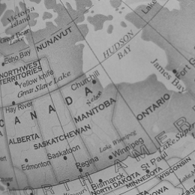

In [24]:
globe_mat = image2array('Globe.png')

# display image
displayImage(globe_mat)

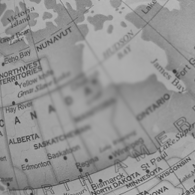

In [25]:
A = 2.0
B = lambda N: - N**2 / (2 * np.log(0.005))

blurred_globe_mat = gaussian_spvar_blur(globe_mat, A, B(globe_mat.shape[0]))

# display image
displayImage(blurred_globe_mat)

This is the required image. As you can see, the blur intensity is radial, most at the center and least around the edges as the $\sigma$ is a gaussian. It is symmetric in `m` and `n`.

Next, in question 2, we are required to blur `Nautilus.png` using two different codes. So we need the space-invariant code from the previous assignment. 

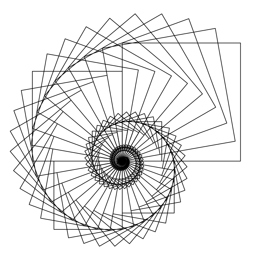

In [26]:
nautilus_mat = image2array('Nautilus.png')

# display image
displayImage(nautilus_mat)

Space Invariant Code: 


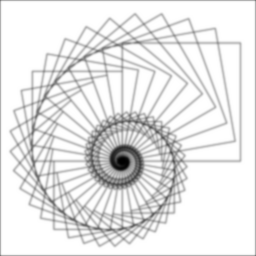

In [27]:
def get_spinvar_kernel(sigma):
    if np.ceil(6 * sigma + 1) % 2 == 0:
        size = np.ceil(6 * sigma + 1) + 1
    else:
        size = np.ceil(6 * sigma + 1)
    
    grid_size = (size-1)/2

    x, y = np.meshgrid(np.arange(-grid_size, grid_size+1), np.arange(-grid_size, grid_size+1))
    
    # gaussian kernel
    if size == 1:  # zero sigma
        kernel = np.ones((1, 1))
    else:
        kernel = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # normalize
    kernel /= np.sum(kernel)

    return kernel    


def gaussian_spinvar_blur(image_mat, sigma):
    # get kernel
    kernel = get_spinvar_kernel(sigma)

    # half kernel size
    hksize = int((kernel.shape[0] - 1) / 2)

    # initialize output image
    blurred_img_mat = np.zeros(image_mat.shape).astype(np.uint8)

    # zero padding
    image_mat_padded = np.pad(image_mat, (hksize, hksize), "constant", constant_values=(0, 0))

    M = kernel.shape[0]  # kernel size
    
    for i in range(blurred_img_mat.shape[0]):
        for j in range(blurred_img_mat.shape[1]):
            conv = image_mat_padded[i:i+M, j:j+M] * kernel
            blurred_img_mat[i, j] = np.sum(conv)

    return blurred_img_mat

spinvar_nautilus_blur = gaussian_spinvar_blur(nautilus_mat, sigma=1.0)
print("Space Invariant Code: ")
displayImage(spinvar_nautilus_blur)

Space Variant Code: 


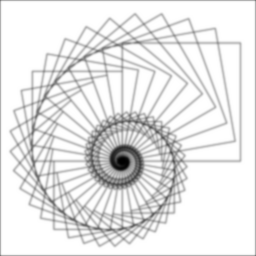

In [29]:
spvar_nautilus_blur = gaussian_spvar_blur(nautilus_mat, A=2.0, B=nautilus_mat.shape[0], force_const_sig=True)
# A and B are dummy values in this case since sigma is forced
print("Space Variant Code: ")
displayImage(spvar_nautilus_blur)

In [34]:
correlation = np.corrcoef(spinvar_nautilus_blur.flatten(), spvar_nautilus_blur.flatten())
print("Correlation Matrix = ")
print(correlation)

Correlation Matrix = 
[[1. 1.]
 [1. 1.]]


One can verify that the two images are the same by observation. However to really check if they are, we find a correlation matrix. The off-diagonal elements correspond to the cross-correlation, they are unity indicating that the two images are practically the same.  